In [1]:
# Import Libraries:

import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
#import graphviz
import shap
import sklearn

from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.inspection import permutation_importance

# Susceptibility to induced seismicity 

## Geoscience BC project

In [2]:
df_well = pd.read_csv('GeologicalDB_Montney_Seismogenic.csv')
df_grid = pd.read_csv('MontneyGrid_GeologicalDB.csv')

## Data split and preprocessing (imputation and scaling)

In [3]:
train, test = train_test_split(df_well, test_size=0.25,random_state=12345) #splitting dataset (75% training size)
X_train = train.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_train = train['Label']
X_test = test.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_test = test['Label']


In [4]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

scaler = StandardScaler() # create feature trasformer object
scaler.fit(X_train_imp) # fitting the transformer on the train split 
X_train_scaled = scaler.transform(X_train_imp) # transforming the train split
X_test_scaled = scaler.transform(X_test_imp) # transforming the test split

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

## Data Before Scaling

In [11]:
pd.DataFrame(X_train, columns = X_train.columns).head()

Bulk_Density    BHCPv  Gamma_Ray  b_value  Seismogenic_index  \
3278       2613.05  4818.33     129.99    1.011              -1.75   
3717       2580.82  4918.76     110.63    0.909              -1.70   
325        2556.44  5008.13     135.27    0.910              -1.68   
3246       2587.94  4743.47     114.94    1.005              -0.90   
2516       2520.95  4988.64     134.87    0.913              -1.67   

      Shear_Strain  Shmin-Mpa  Shmax_variation  PP_grad  ppgrad_std  ...  \
3278          4.50      51.35             8.02    11.70    1.408559  ...   
3717          4.32      35.28             5.25     7.00    2.217854  ...   
325           4.41      40.52             3.36    12.38    0.880610  ...   
3246          4.45      41.24             6.73    12.36    3.932977  ...   
2516          4.43      40.63             3.27    11.58    0.777588  ...   

      Max_Pb  Dist_TopMon  Dist_MidMon  Dist_Deb/Bell  Dist_Base  \
3278   56.53       216.15       116.14         -80.62   -1286.44   
3717   44.20       218.87       107.95         -95.89   -1532.80   
325    61.72        49.35       -22.21        -260.02   -1267.20   
3246   58.10        95.16         7.24        -193.36   -1754.60   
2516   58.00       257.28        84.76         -50.98   -1294.46   

      Montney-Thikness_CW  WellDensity-1km  WellDensity-3km  WellDensity-5km  \
3278               296.77                0                0                0   
3717               314.76                0                0                0   
325                309.37                1               20               49   
3246               288.52                0                0                0   
2516               308.26                0                0                1   

      WellDensity-10km  
3278                 1  
3717                 3  
325                139  
3246                 4  
2516                26  

[5 rows x 25 columns]

## Data After Scaling

In [9]:
pd.DataFrame(X_train_scaled, columns = X_train.columns).head()

Bulk_Density     BHCPv  Gamma_Ray   b_value  Seismo_index  Shear_Strain  \
0      0.820194 -0.092609   0.454117  0.708688     -1.150418      0.175886   
1      0.154944  0.749573  -0.765508 -0.599700     -1.004960     -1.102320   
2     -0.348276  1.499008   0.786742 -0.586873     -0.946776     -0.463217   
3      0.301906 -0.720366  -0.493990  0.631724      1.322373     -0.179171   
4     -1.080815  1.335570   0.761544 -0.548391     -0.917685     -0.321194   

      Shmin  Shmax_variation   PP_grad  ppgrad_SD  ...  Dist_CTB  Max_ISIP  \
0  1.476698         1.156502 -0.402693  -0.348302  ...  0.616533  0.163335   
1 -0.903746         0.003641 -3.121559   0.335259  ...  1.450669 -1.049269   
2 -0.127547        -0.782968 -0.009325  -0.794227  ...  0.921480  0.080616   
3 -0.020893         0.619610 -0.020895   1.783916  ... -1.225951 -0.422060   
4 -0.111252        -0.820426 -0.472111  -0.881243  ...  0.827673  1.986785   

     Max_Pb  Dist_TopMon  Dist_MidMon  Dist_Basement  Mon_Thickness  \
0 -0.055139     1.077899     1.173318       1.430987       0.036378   
1 -1.485485     1.105095     1.090991       0.349623       0.697176   
2  0.546929    -0.589861    -0.217388       1.515439       0.499193   
3  0.126990    -0.131827     0.078646      -0.623938      -0.266656   
4  0.115389     1.489140     0.857883       1.395785       0.458422   

   WellDensity-1km  WellDensity-3km  WellDensity-10km  
0        -0.287957        -0.465226         -0.669914  
1        -0.287957        -0.465226         -0.641499  
2         0.287087         1.655092          1.290671  
3        -0.287957        -0.465226         -0.627292  
4        -0.287957        -0.465226         -0.314735  

[5 rows x 23 columns]

In [28]:
X_train_scaled.sort_values('WellDensity-1km').tail(400)

Bulk_Density     BHCPv  Gamma_Ray   b_value  Seismo_index  Shear_Strain  \
1966      0.622043 -0.119778   1.157166  0.311041     -0.917685      0.246897   
1113      0.266404 -0.097221  -0.058050 -0.497082     -0.044935      0.388920   
806       0.363002 -0.786027   0.359622  0.490623      0.944181     -0.179171   
560       0.635666 -1.077180  -0.202313  0.554760      1.293281      1.951172   
592       0.746919 -1.595588   1.026762 -0.176398      1.293281      1.951172   
...            ...       ...        ...       ...           ...           ...   
2127     -2.109960  0.678294  -0.194753 -0.381636     -0.830410      0.033863   
2213      0.296126  0.397036   1.441283 -0.343154     -0.015843      0.317909   
3256     -0.488633  0.209111   0.154881 -0.432945     -0.946776     -0.747263   
3073     -0.118958  0.599300  -0.722670 -0.522736     -0.975868     -0.960297   
3025     -0.222781 -1.872737  -0.791967  0.554760      1.322373     -0.037148   

         Shmin  Shmax_variation   PP_grad  ppgrad_SD  ...  Dist_CTB  Max_ISIP  \
1966  1.725556         1.035805  0.198928  -1.063806  ...  0.581988  0.736913   
1113 -0.401587        -0.966094  0.800550  -0.002460  ...  0.170430 -0.258441   
806   0.036877        -0.812102 -0.078743  -0.829331  ... -1.552339 -0.412970   
560   1.324125         1.481134  1.014588  -0.623890  ... -1.565740  0.650558   
592   0.691611         0.736145  0.060093   0.182768  ... -1.491588  2.098592   
...        ...              ...       ...        ...  ...       ...       ...   
2127  0.393870        -0.720539  0.389827  -1.371455  ...  0.658523  2.223125   
2213 -0.508240        -0.491631  1.274905  -0.500891  ...  0.247858 -0.925645   
3256 -0.665257        -0.258562 -2.462090   0.539586  ...  1.174013 -1.367418   
3073 -0.724509        -0.092084 -0.720858   0.284825  ...  1.336314 -1.012909   
3025 -0.041631         0.394865 -0.558883   1.305786  ... -1.494566 -0.685670   

        Max_Pb  Dist_TopMon  Dist_MidMon  Dist_Basement  Mon_Thickness  \
1966  0.776620     1.354559     1.099736       1.263928      -0.040758   
1113  0.393802     1.448545     0.961621      -0.651152      -0.818728   
806   0.370601     0.689755     0.977202       1.201160      -0.310733   
560   0.544609    -0.252109    -0.519755       0.330266       2.339435   
592   0.614212    -0.508373     0.575922      -0.878082       0.617836   
...        ...          ...          ...            ...            ...   
2127  0.579411     0.709052     0.142577      -0.807852      -0.099895   
2213 -0.789452    -0.825227    -0.782315      -1.575728      -0.799995   
3256 -1.357879     2.000566     1.704972       0.569530      -1.299175   
3073  0.695416     0.288813     0.623167       0.264031       0.347493   
3025 -0.047018     0.363902     0.400815      -0.346267      -0.262615   

      WellDensity-1km  WellDensity-3km  WellDensity-10km  
1966         0.287087        -0.147178          0.154100  
1113         0.287087        -0.359210          1.461157  
806          0.287087         1.867124          1.688471  
560          0.287087        -0.359210         -0.300528  
592          0.287087         0.912981          0.196722  
...               ...              ...               ...  
2127         9.487786         2.503219          1.375914  
2213        10.637874         2.291188          1.091771  
3256        10.637874         9.394254          4.174720  
3073        13.513092         7.910031          4.657763  
3025        18.688486         6.425808          5.410741  

[400 rows x 23 columns]

In [25]:
d = X_train.min(),X_train.max(),X_train.mean(),X_train.std(),((X_train.max()-X_train.mean())/X_train.std()),((X_train.min()-X_train.mean())/X_train.std())
df = pd.DataFrame(data=d)

In [26]:
df.T

0            1            2           3  \
Bulk_Density      2273.120000  2796.360000  2573.313278   48.455300   
BHCPv             3878.100000  5455.100000  4829.373547  119.267828   
Gamma_Ray           16.510000   173.220000   122.781464   15.876131   
b_value              0.714000     1.477000     0.955752    0.077970   
Seismo_index        -2.030000    -0.850000    -1.354554    0.343793   
Shear_Strain         3.980000     4.870000     4.475231    0.140844   
Shmin               13.610000    61.780000    41.381046    6.751860   
Shmax_variation      0.040000    11.480000     5.241252    2.403081   
PP_grad              6.310000    17.540000    12.396120    1.728923   
ppgrad_SD            0.104069     7.463397     1.820927    1.184119   
Montney-Top       1303.340000  3493.830000  2060.556659  265.428735   
Basement_Top      2602.960000  5099.630000  3781.353574  333.101119   
Dist_Faults          0.000000    28.570000     3.489114    3.159670   
Dist_CTB             0.000000   135.770000    59.537024   33.584741   
Max_ISIP            11.100000    86.900000    34.850972   11.025498   
Max_Pb              24.640000    90.900000    57.001233    8.641008   
Dist_TopMon        -99.750000   467.180000   108.344581  100.029533   
Dist_MidMon       -289.510000   384.230000    -0.583834   99.496907   
Dist_Basement    -2338.050000  -783.350000 -1612.452334  227.857815   
Mon_Thickness      222.900000   506.290000   295.779619   27.228798   
WellDensity-1km      0.000000    33.000000     0.500756    1.739261   
WellDensity-3km      0.000000    99.000000     4.388267    9.433973   
WellDensity-10km     0.000000   459.000000    48.153311   70.397801   

                          4         5  
Bulk_Density       4.603144 -6.195262  
BHCPv              5.246398 -7.975944  
Gamma_Ray          3.177004 -6.693789  
b_value            6.685216 -3.100562  
Seismo_index       1.467609 -1.964687  
Shear_Strain       2.802886 -3.516178  
Shmin              3.021235 -4.113096  
Shmax_variation    2.596145 -2.164409  
PP_grad            2.975193 -3.520180  
ppgrad_SD          4.765121 -1.449904  
Montney-Top        5.399842 -2.852806  
Basement_Top       3.957586 -3.537645  
Dist_Faults        7.937819 -1.104265  
Dist_CTB           2.269869 -1.772740  
Max_ISIP           4.720787 -2.154186  
Max_Pb             3.923011 -3.745076  
Dist_TopMon        3.587295 -2.080331  
Dist_MidMon        3.867596 -2.903871  
Dist_Basement      3.638683 -3.184432  
Mon_Thickness      7.731167 -2.676564  
WellDensity-1km   18.685660 -0.287913  
WellDensity-3km   10.028833 -0.465156  
WellDensity-10km   5.836073 -0.684017

In [12]:
X_train.max()

Bulk_Density        2796.360000
BHCPv               5455.100000
Gamma_Ray            173.220000
b_value                1.477000
Seismo_index          -0.850000
Shear_Strain           4.870000
Shmin                 61.780000
Shmax_variation       11.480000
PP_grad               17.540000
ppgrad_SD              7.463397
Montney-Top         3493.830000
Basement_Top        5099.630000
Dist_Faults           28.570000
Dist_CTB             135.770000
Max_ISIP              86.900000
Max_Pb                90.900000
Dist_TopMon          467.180000
Dist_MidMon          384.230000
Dist_Basement       -783.350000
Mon_Thickness        506.290000
WellDensity-1km       33.000000
WellDensity-3km       99.000000
WellDensity-10km     459.000000
dtype: float64

In [9]:
X_train.std()

Bulk_Density         48.455300
BHCPv               119.267828
Gamma_Ray            15.876131
b_value               0.077970
Seismo_index          0.343793
Shear_Strain          0.140844
Shmin                 6.751860
Shmax_variation       2.403081
PP_grad               1.728923
ppgrad_SD             1.184119
Montney-Top         265.428735
Basement_Top        333.101119
Dist_Faults           3.159670
Dist_CTB             33.584741
Max_ISIP             11.025498
Max_Pb                8.641008
Dist_TopMon         100.029533
Dist_MidMon          99.496907
Dist_Basement       227.857815
Mon_Thickness        27.228798
WellDensity-1km       1.739261
WellDensity-3km       9.433973
WellDensity-10km     70.397801
dtype: float64

In [6]:
# Calculating Scores
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


results = dict()

In [7]:
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

models = {
        
    
    'Dummy_Classifier'   : DummyClassifier(strategy="most_frequent"),
    'LogisticRegression' : LogisticRegression(class_weight="balanced"),
    'decision tree'      : DecisionTreeClassifier(class_weight="balanced"),
    'random forest'      : RandomForestClassifier(class_weight="balanced"),
    'SVC'                : SVC(class_weight="balanced"),
    'KNN'                : KNeighborsClassifier(), 
    'XGBoost'            : xgb.XGBClassifier()
#    'lightGBM'           : lgb.LGBClassifier() #### balanced class weight
         }

scores = dict()

for model_name, model in models.items():
#    print(model_name)
    scores[model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=5, scoring=scoring_list)

pd.DataFrame.from_dict(scores, orient='index')
#pd.DataFrame.from_dict(scores, orient='index').drop(columns=['fit_time','score_time','train_f1','train_precision','train_recall'])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

[09:05:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:20] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


fit_time         score_time      test_accuracy  \
Dummy_Classifier    0.001 (+/- 0.001)  0.004 (+/- 0.001)  0.801 (+/- 0.001)   
LogisticRegression  0.016 (+/- 0.002)  0.006 (+/- 0.001)  0.640 (+/- 0.026)   
decision tree       0.038 (+/- 0.005)  0.005 (+/- 0.001)  0.850 (+/- 0.016)   
random forest       0.489 (+/- 0.026)  0.020 (+/- 0.001)  0.891 (+/- 0.012)   
SVC                 0.243 (+/- 0.007)  0.108 (+/- 0.003)  0.725 (+/- 0.020)   
KNN                 0.003 (+/- 0.002)  0.052 (+/- 0.005)  0.842 (+/- 0.010)   
XGBoost             0.187 (+/- 0.011)  0.007 (+/- 0.001)  0.893 (+/- 0.008)   

                       train_accuracy        test_recall       train_recall  \
Dummy_Classifier    0.801 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
LogisticRegression  0.646 (+/- 0.005)  0.592 (+/- 0.056)  0.625 (+/- 0.029)   
decision tree       1.000 (+/- 0.000)  0.633 (+/- 0.032)  1.000 (+/- 0.000)   
random forest       1.000 (+/- 0.000)  0.584 (+/- 0.056)  1.000 (+/- 0.000)   
SVC                 0.773 (+/- 0.006)  0.843 (+/- 0.027)  0.948 (+/- 0.006)   
KNN                 0.894 (+/- 0.005)  0.530 (+/- 0.060)  0.670 (+/- 0.020)   
XGBoost             1.000 (+/- 0.000)  0.616 (+/- 0.063)  1.000 (+/- 0.000)   

                       test_precision    train_precision            test_f1  \
Dummy_Classifier    0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
LogisticRegression  0.297 (+/- 0.023)  0.308 (+/- 0.004)  0.395 (+/- 0.029)   
decision tree       0.622 (+/- 0.050)  1.000 (+/- 0.000)  0.627 (+/- 0.035)   
random forest       0.821 (+/- 0.059)  1.000 (+/- 0.000)  0.681 (+/- 0.042)   
SVC                 0.408 (+/- 0.019)  0.465 (+/- 0.006)  0.549 (+/- 0.018)   
KNN                 0.622 (+/- 0.044)  0.766 (+/- 0.015)  0.569 (+/- 0.033)   
XGBoost             0.802 (+/- 0.026)  1.000 (+/- 0.000)  0.695 (+/- 0.036)   

                             train_f1  
Dummy_Classifier    0.000 (+/- 0.000)  
LogisticRegression  0.412 (+/- 0.009)  
decision tree       1.000 (+/- 0.000)  
random forest       1.000 (+/- 0.000)  
SVC                 0.624 (+/- 0.005)  
KNN                 0.715 (+/- 0.016)  
XGBoost             1.000 (+/- 0.000)

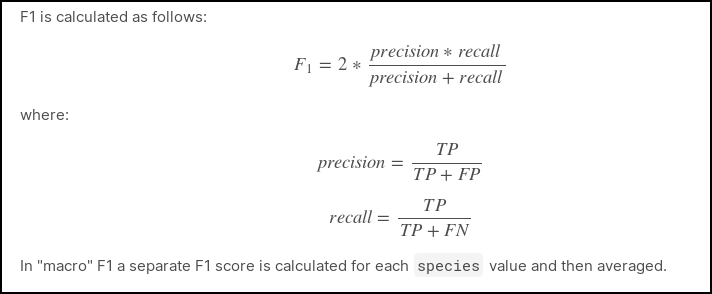

- Precision can be seen as a measure of quality, and recall (sensitivity) as a measure of quantity.
- Higher precision means that an algorithm returns more relevant results than irrelevant ones.
- high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).

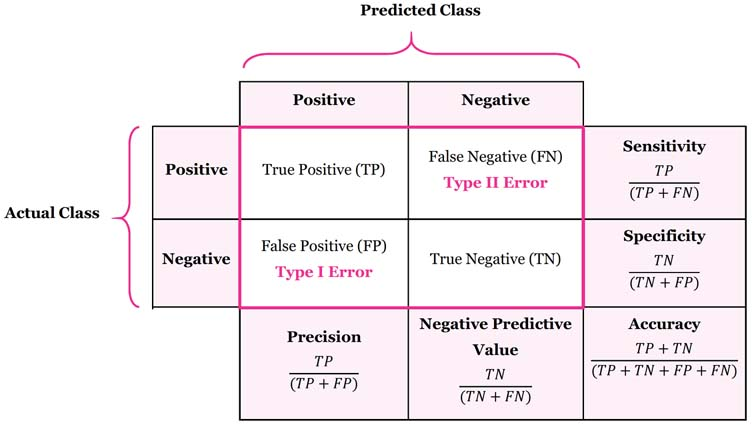

# Hyperparameter Optimization
- Bayesian search with Balanced class weight


In [10]:
import warnings
warnings.filterwarnings('ignore')
#### Logistic regression

optlr = BayesSearchCV(
    LogisticRegression(class_weight='balanced'),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'max_iter': (1e+2, 1e+5, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlr.fit(X_train_scaled, y_train)

print("LR train score: %s" % optlr.best_score_)
print("LR test score: %s" % optlr.score(X_test_scaled, y_test))
print("LR best params: %s" % str(optlr.best_params_))

##### Decision Tree

optdt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optdt.fit(X_train_scaled, y_train)

print("DT train score: %s" % optdt.best_score_)
print("DT test score: %s" % optdt.score(X_test_scaled, y_test))
print("DT best params: %s" % str(optdt.best_params_))


##### Random Forest

optrf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optrf.fit(X_train_scaled, y_train)

print("RF train score: %s" % optrf.best_score_)
print("RF test score: %s" % optrf.score(X_test_scaled, y_test))
print("RF best params: %s" % str(optrf.best_params_))


##### SVC
optsvc = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        #'degree': (1, 8),  # integer valued parameter
        #'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=5
)

optsvc.fit(X_train_scaled, y_train)

print("SVC train score: %s" % optsvc.best_score_)
print("SVC test score: %s" % optsvc.score(X_test_scaled, y_test))
print("SVC best params: %s" % str(optsvc.best_params_))

###### KNN

optknn = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (3, 10, 'log-uniform'),
        'leaf_size': (10, 50, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optknn.fit(X_train_scaled, y_train)

print("KNN Opt train score: %s" % optknn.best_score_)
print("KNN Opt test score: %s" % optknn.score(X_test_scaled, y_test))
print("KNN Opt best params: %s" % str(optknn.best_params_))



LR train score: 0.6492289083761718
LR test score: 0.6545784224841342
LR best params: OrderedDict([('C', 0.02362273955271446), ('max_iter', 100000.0)])
DT train score: 0.8563652857574842
DT test score: 0.8730734360834089
DT best params: OrderedDict([('max_depth', 100)])
RF train score: 0.8974901723616571
RF test score: 0.900271985494107
RF best params: OrderedDict([('max_depth', 51)])
SVC train score: 0.8506198971877835
SVC test score: 0.8540344514959202
SVC best params: OrderedDict([('C', 985993.8474386618), ('gamma', 0.5643214648329259)])
KNN Opt train score: 0.8424553976413668
KNN Opt test score: 0.8422484134179511
KNN Opt best params: OrderedDict([('leaf_size', 33), ('n_neighbors', 8)])


In [15]:

optgb = BayesSearchCV(
    ensemble.GradientBoostingClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optgb.fit(X_train_scaled, y_train)

print("GB Opt train score: %s" % optgb.best_score_)
print("GB Opt test score: %s" % optgb.score(X_test_scaled, y_test))
print("GB Opt best params: %s" % str(optgb.best_params_))

GB Opt train score: 0.892651950408225
GB Opt test score: 0.8930190389845875
GB Opt best params: OrderedDict([('learning_rate', 0.35648409726932095), ('n_estimators', 771)])


In [10]:
##### XGBoost

optxgb = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        'eta': (1e-6, 0.9, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optxgb.fit(X_train_scaled, y_train)

print("XGB Opt train score: %s" % optxgb.best_score_)
print("XGB Opt test score: %s" % optxgb.score(X_test_scaled, y_test))
print("XGB Opt best params: %s" % str(optxgb.best_params_))

The objective has been evaluated at this point before.


XGB Opt train score: 0.8990021167221046
XGB Opt test score: 0.8939256572982774
XGB Opt best params: OrderedDict([('eta', 1.6630870675319177e-05), ('gamma', 0.04574552576349154), ('max_depth', 79)])


In [7]:
### lightgbm.LGBMClassifier
optlgb = BayesSearchCV(
    lgb.LGBMClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'num_leaves': (10, 100, 'log-uniform'),
        'max_depth': (1, 32, 'log-uniform'),
        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlgb.fit(X_train_scaled, y_train)

print("LGB Opt train score: %s" % optlgb.best_score_)
print("LGB Opt test score: %s" % optlgb.score(X_test_scaled, y_test))
print("LGB Opt best params: %s" % str(optlgb.best_params_))

TypeError: __init__() got an unexpected keyword argument 'iid'

In [14]:
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

models = {
        
    
    'Dummy_Classifier'   : DummyClassifier(strategy="most_frequent"),
    'LogisticRegression' : LogisticRegression(C=0.0277167250884867, max_iter=100,class_weight='balanced'),
    'decision tree'      : DecisionTreeClassifier(max_depth= 93),
    'random forest'      : RandomForestClassifier(max_depth= 28),
    'SVC'                : SVC(C= 977647.5158109494,gamma=0.4890729726218923),
    'KNN'                : KNeighborsClassifier(leaf_size= 16,n_neighbors= 8), 
    'XGBoost'            : xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79),
    'lightGBM'           : lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 95,n_estimators=467,num_leaves= 80) #### balanced class weight
         }

scoresAll = dict()

for model_name, model in models.items():
    print(model_name)
    scoresAll[model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=50, scoring=scoring_list)

pd.DataFrame.from_dict(scoresAll, orient='index')

Dummy_Classifier
LogisticRegression
decision tree
random forest
SVC
KNN
XGBoost
lightGBM


fit_time         score_time      test_accuracy  \
Dummy_Classifier    0.001 (+/- 0.001)  0.002 (+/- 0.000)  0.801 (+/- 0.004)   
LogisticRegression  0.020 (+/- 0.002)  0.002 (+/- 0.000)  0.639 (+/- 0.066)   
decision tree       0.036 (+/- 0.001)  0.002 (+/- 0.000)  0.861 (+/- 0.036)   
random forest       0.507 (+/- 0.010)  0.009 (+/- 0.001)  0.904 (+/- 0.030)   
SVC                 0.457 (+/- 0.015)  0.007 (+/- 0.001)  0.858 (+/- 0.041)   
KNN                 0.017 (+/- 0.001)  0.012 (+/- 0.001)  0.844 (+/- 0.034)   
XGBoost             1.148 (+/- 0.026)  0.003 (+/- 0.000)  0.904 (+/- 0.032)   
lightGBM            1.579 (+/- 0.100)  0.007 (+/- 0.001)  0.905 (+/- 0.035)   

                       train_accuracy        test_recall       train_recall  \
Dummy_Classifier    0.801 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
LogisticRegression  0.649 (+/- 0.002)  0.591 (+/- 0.118)  0.615 (+/- 0.005)   
decision tree       1.000 (+/- 0.000)  0.659 (+/- 0.109)  1.000 (+/- 0.000)   
random forest       1.000 (+/- 0.000)  0.641 (+/- 0.125)  1.000 (+/- 0.000)   
SVC                 1.000 (+/- 0.000)  0.447 (+/- 0.154)  1.000 (+/- 0.000)   
KNN                 0.877 (+/- 0.001)  0.416 (+/- 0.127)  0.514 (+/- 0.006)   
XGBoost             1.000 (+/- 0.000)  0.662 (+/- 0.137)  1.000 (+/- 0.000)   
lightGBM            1.000 (+/- 0.000)  0.660 (+/- 0.137)  1.000 (+/- 0.000)   

                       test_precision    train_precision            test_f1  \
Dummy_Classifier    0.000 (+/- 0.000)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
LogisticRegression  0.301 (+/- 0.061)  0.308 (+/- 0.002)  0.396 (+/- 0.071)   
decision tree       0.658 (+/- 0.111)  1.000 (+/- 0.000)  0.652 (+/- 0.086)   
random forest       0.850 (+/- 0.102)  1.000 (+/- 0.000)  0.722 (+/- 0.099)   
SVC                 0.741 (+/- 0.192)  1.000 (+/- 0.000)  0.546 (+/- 0.149)   
KNN                 0.682 (+/- 0.168)  0.794 (+/- 0.005)  0.508 (+/- 0.129)   
XGBoost             0.823 (+/- 0.100)  1.000 (+/- 0.000)  0.726 (+/- 0.107)   
lightGBM            0.833 (+/- 0.113)  1.000 (+/- 0.000)  0.729 (+/- 0.111)   

                             train_f1  
Dummy_Classifier    0.000 (+/- 0.000)  
LogisticRegression  0.410 (+/- 0.003)  
decision tree       1.000 (+/- 0.000)  
random forest       1.000 (+/- 0.000)  
SVC                 1.000 (+/- 0.000)  
KNN                 0.624 (+/- 0.005)  
XGBoost             1.000 (+/- 0.000)  
lightGBM            1.000 (+/- 0.000)

# Model performance after hyperparameter optimization

In [15]:
table = pd.DataFrame.from_dict(scoresAll, orient='index').drop(columns=['fit_time','score_time','train_accuracy','train_f1','train_precision','train_recall'])
table.to_excel("output.xlsx")
table

test_accuracy        test_recall     test_precision  \
Dummy_Classifier    0.801 (+/- 0.004)  0.000 (+/- 0.000)  0.000 (+/- 0.000)   
LogisticRegression  0.639 (+/- 0.066)  0.591 (+/- 0.118)  0.301 (+/- 0.061)   
decision tree       0.861 (+/- 0.036)  0.659 (+/- 0.109)  0.658 (+/- 0.111)   
random forest       0.904 (+/- 0.030)  0.641 (+/- 0.125)  0.850 (+/- 0.102)   
SVC                 0.858 (+/- 0.041)  0.447 (+/- 0.154)  0.741 (+/- 0.192)   
KNN                 0.844 (+/- 0.034)  0.416 (+/- 0.127)  0.682 (+/- 0.168)   
XGBoost             0.904 (+/- 0.032)  0.662 (+/- 0.137)  0.823 (+/- 0.100)   
lightGBM            0.905 (+/- 0.035)  0.660 (+/- 0.137)  0.833 (+/- 0.113)   

                              test_f1  
Dummy_Classifier    0.000 (+/- 0.000)  
LogisticRegression  0.396 (+/- 0.071)  
decision tree       0.652 (+/- 0.086)  
random forest       0.722 (+/- 0.099)  
SVC                 0.546 (+/- 0.149)  
KNN                 0.508 (+/- 0.129)  
XGBoost             0.726 (+/- 0.107)  
lightGBM            0.729 (+/- 0.111)

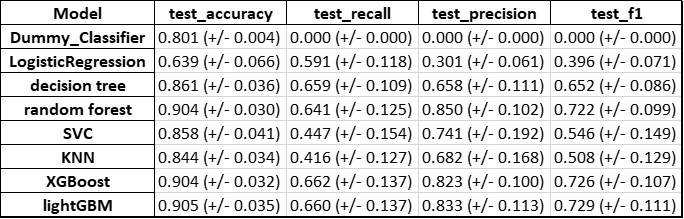

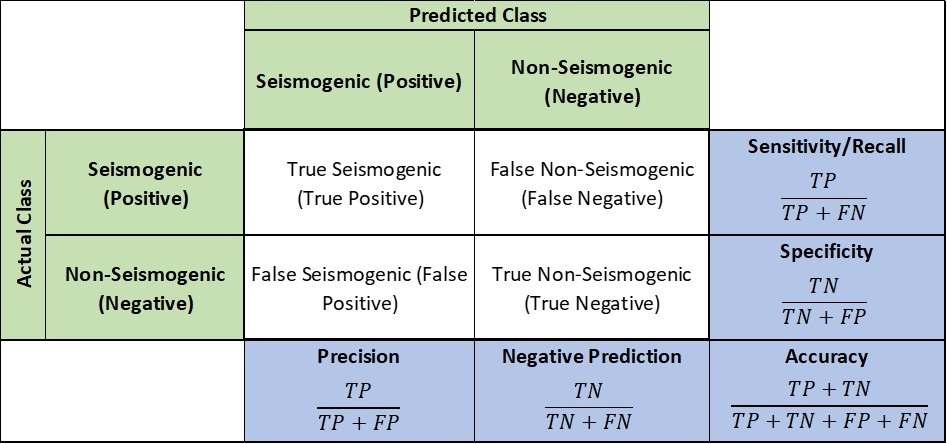

# Best model: Light GBM
- similar f1 score to XGBoost and Random Forest but faster

# Model performance on validation set

F1 Score: Random Forest [0.93846154 0.70984456]
[11:09:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 Score: XGBoost [0.91263216 0.61613692]
F1 Score: Light GBM [0.92943201 0.73434125]


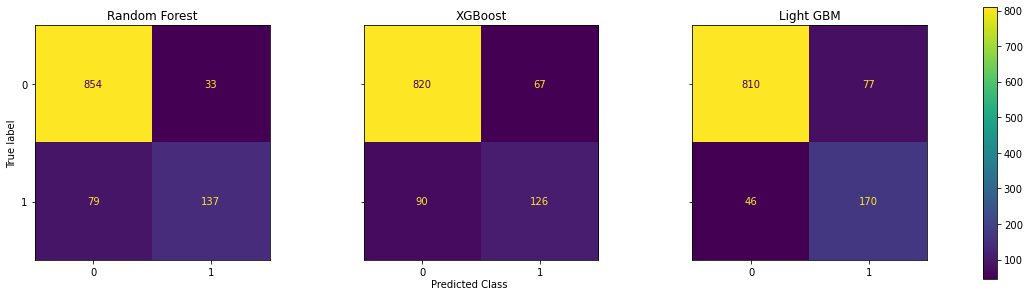

In [18]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 28),
    "XGBoost": xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79,use_label_encoder=False),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80,class_weight='balanced')
                }


f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
    print("F1 Score: %s" % key , f1_score(y_test, y_pred, average=None))
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                  display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted Class', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()
f.savefig('Validation_ConfMatrix_300dpi', dpi=300)

# Model Interpretation

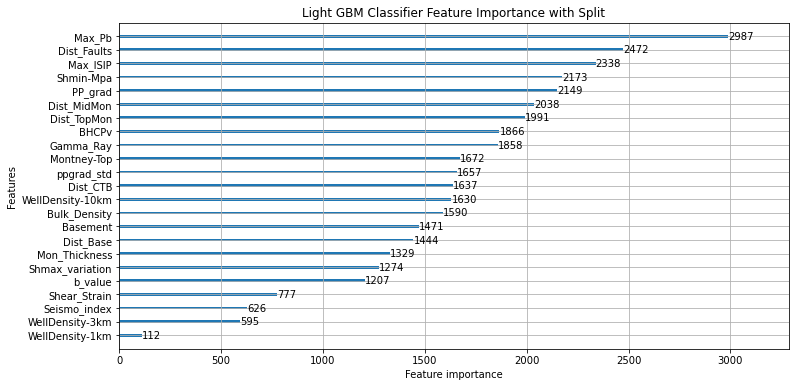

In [10]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80).fit(X_train_scaled, y_train)
lgb.plot_importance(model)
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance with Split")
fig.set_figheight(6)
fig.set_figwidth(12)
plt.savefig('LGB_C_FIsplit_200dpi.png', dpi=200)


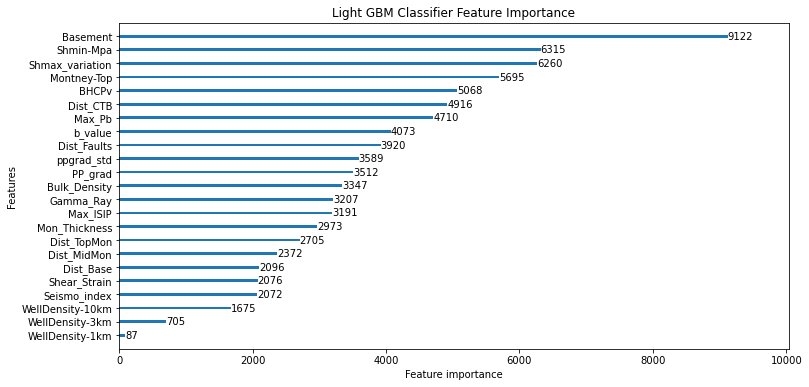

In [19]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80).fit(X_train_scaled, y_train)
lgb.plot_importance(model, importance_type='gain', grid=False ,precision=0)
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance")
fig.set_figheight(6)
fig.set_figwidth(12)
plt.savefig('LGBM_C_FI_200dpi.png', dpi=200)

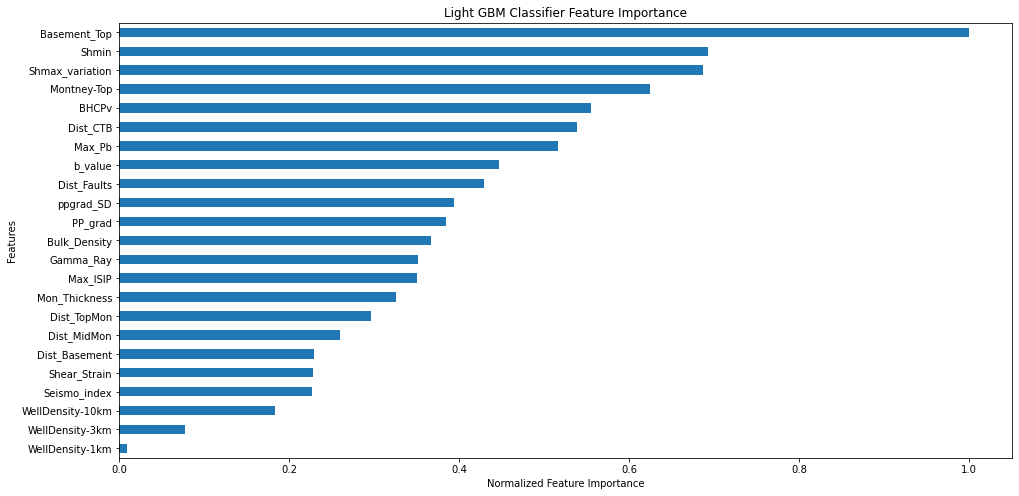

In [7]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80,importance_type='gain')
model.fit(X_train_scaled, y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('LGBM_C_FInorm_GOP_200dpi.png', dpi=200)

In [5]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(max_depth= 28)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=28)

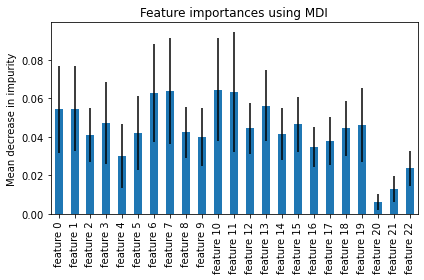

In [6]:
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

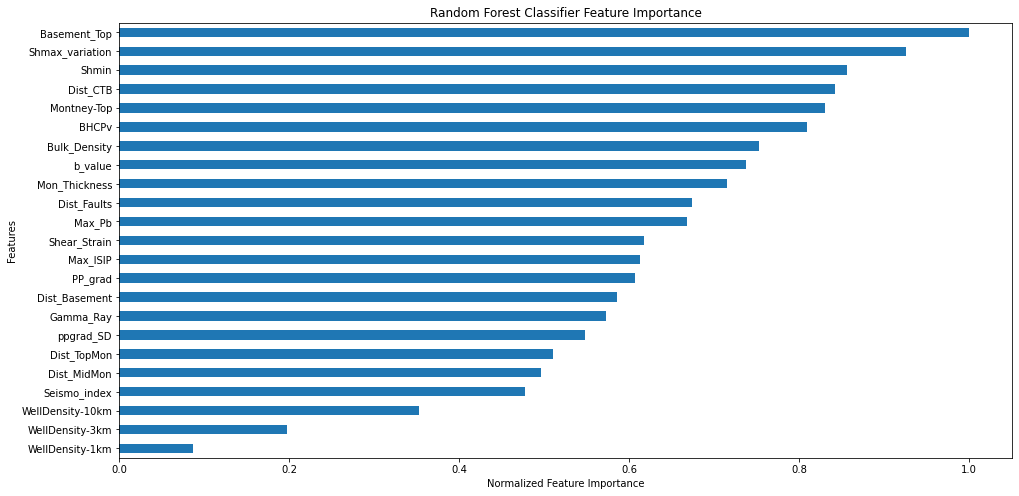

In [6]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(max_depth= 28)
forest.fit(X_train_scaled, y_train)
feat_importances = pd.Series(forest.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Random Forest Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('RF_C_FInorm_200dpi.png', dpi=200)

In [ ]:
feat_importances = pd.Series(forest.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()*100000
fig = plt.gcf()
plt.title("Random Forest Classifier Feature Importance")
fig.set_figheight(6)
fig.set_figwidth(12)
feat_importances.plot(kind='barh')
plt.savefig('RF_C_FI_200dpi.png', dpi=200)

## PDP and ICE plts (Light GBM)

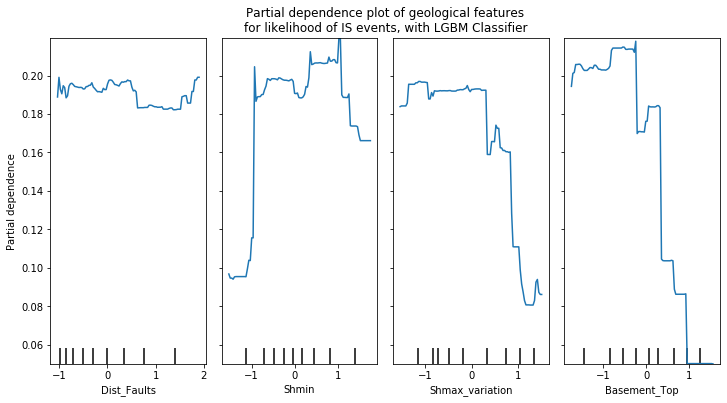

In [5]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80).fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Partial dependence plot of geological features\n"
    "for likelihood of IS events, with LGBM Classifier")
display = plot_partial_dependence(model, X_train_scaled, ['Dist_Faults','Shmin','Shmax_variation','Basement_Top'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_lgbm_C_200dpi_small', dpi=200)

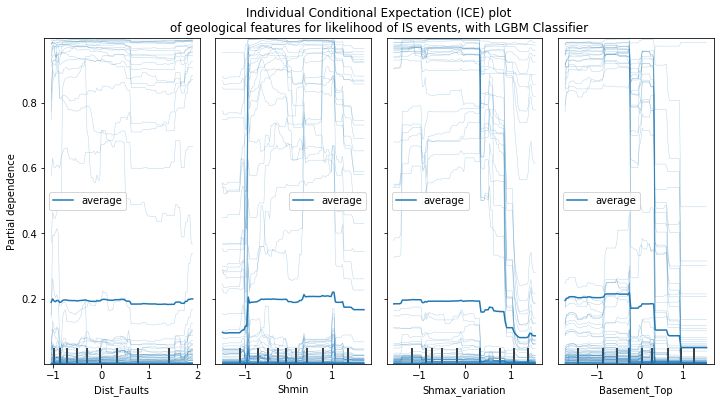

In [6]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Individual Conditional Expectation (ICE) plot\n"
    "of geological features for likelihood of IS events, with LGBM Classifier")
display = plot_partial_dependence(model, X_train_scaled, ['Dist_Faults','Shmin','Shmax_variation','Basement_Top'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_lgbm_C_200dpi_small', dpi=200)

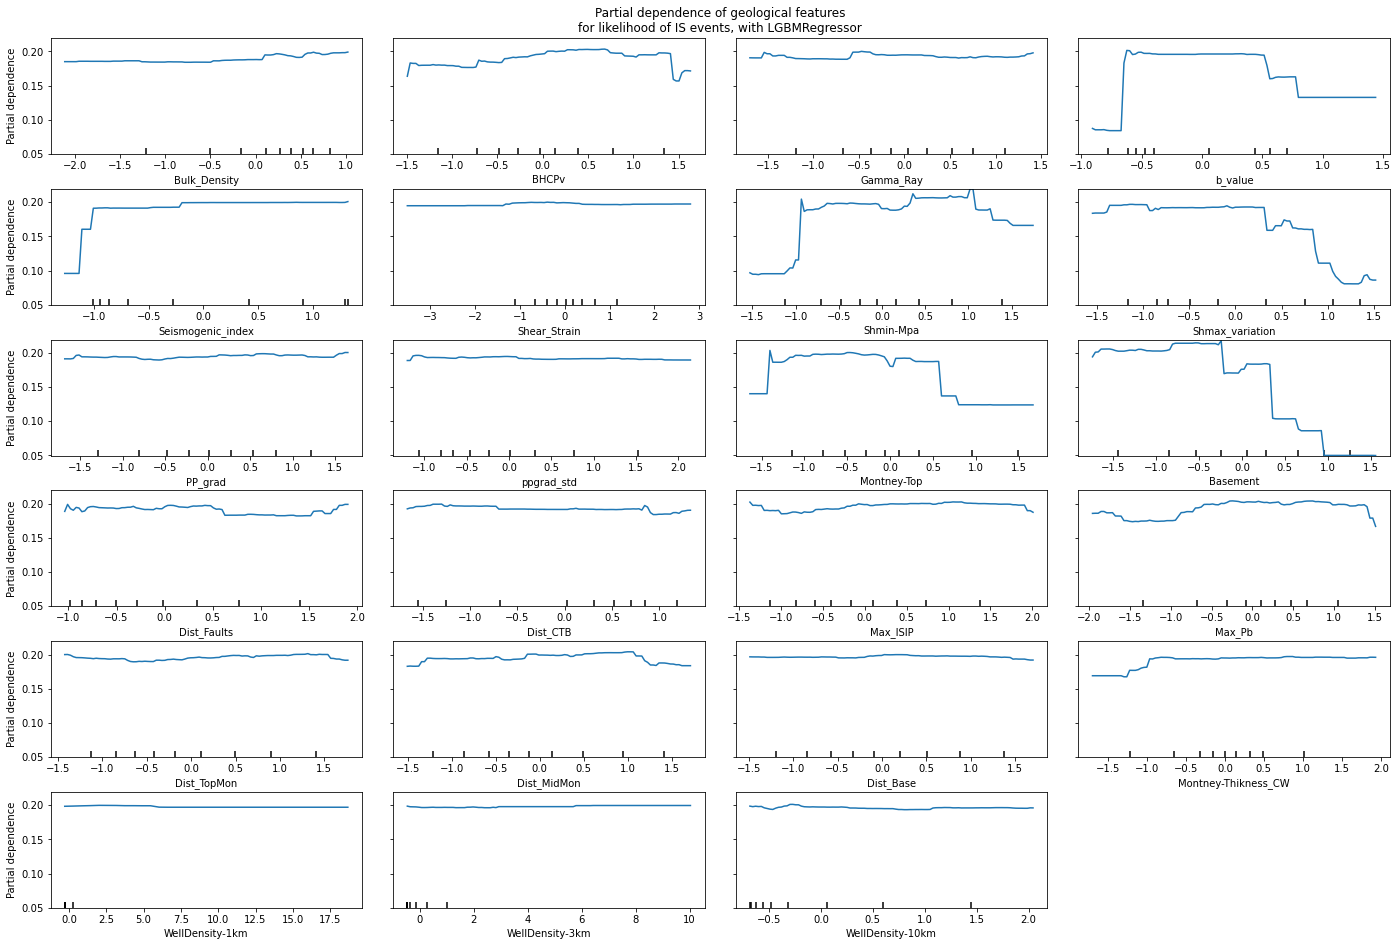

In [20]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Partial dependence plot of geological features\n"
    "for likelihood of IS events, with LGBM Classifier")
display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismogenic_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_lgbmC_100dpi', dpi=100)

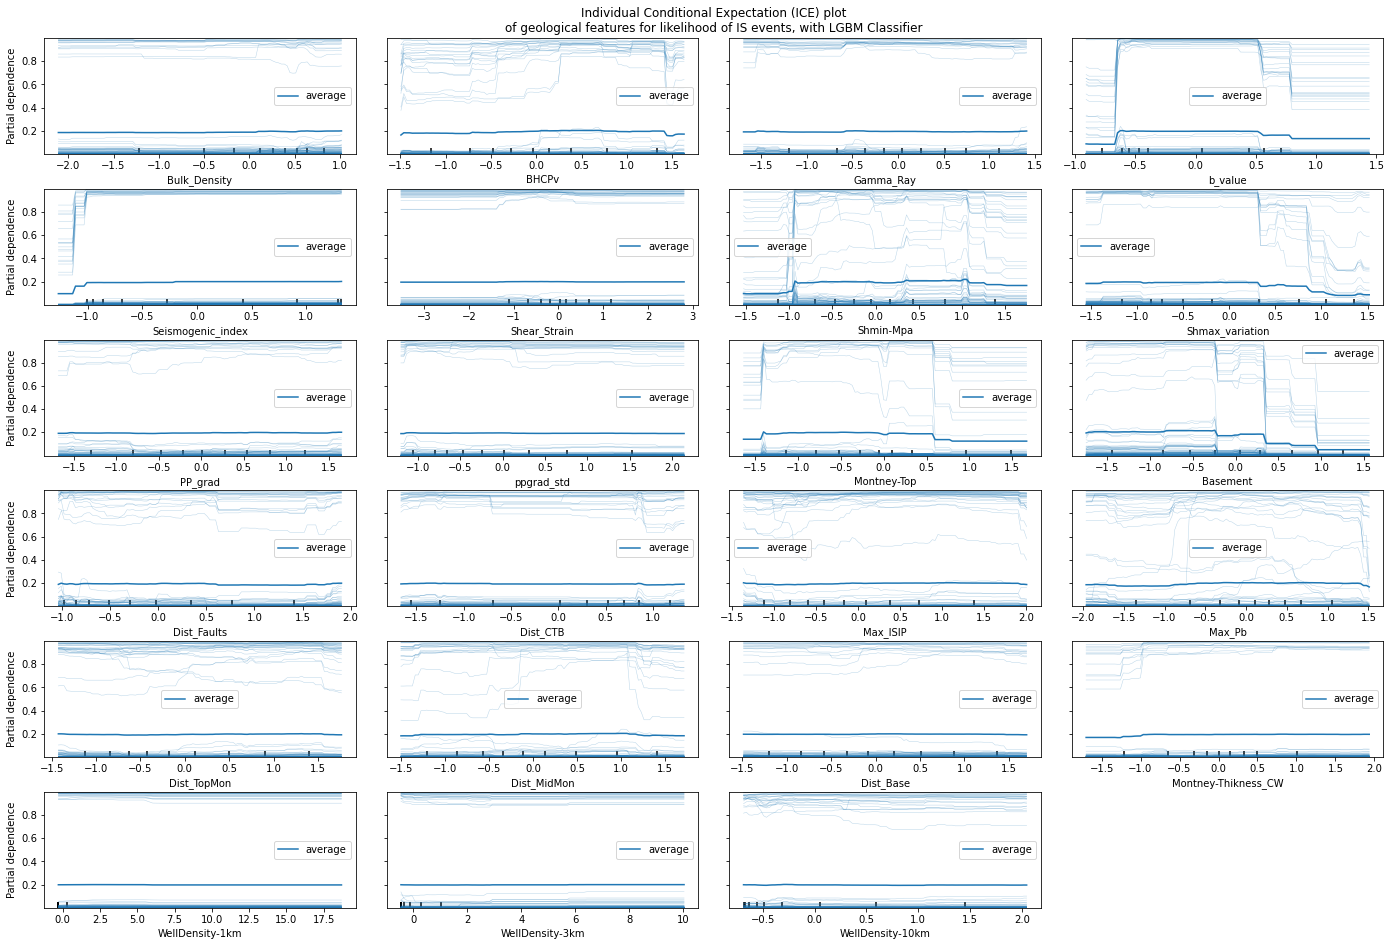

In [22]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Individual Conditional Expectation (ICE) plot\n"
    "of geological features for likelihood of IS events, with LGBM Classifier")
display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismogenic_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_plot_lgbmC_300dpi', dpi=300)

## PDP and ICE plts (Random Forest)

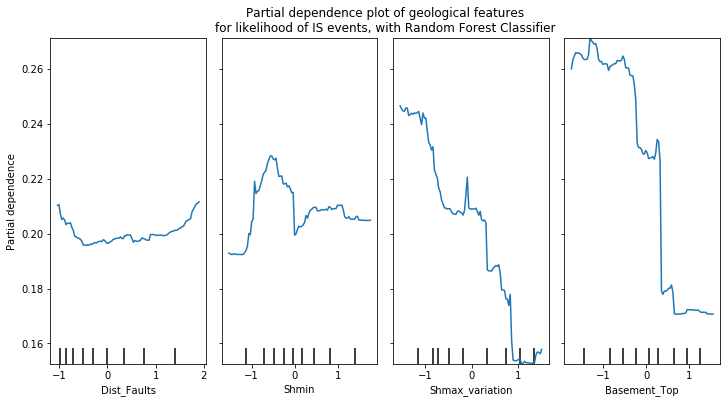

In [8]:
modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Partial dependence plot of geological features\n"
    "for likelihood of IS events, with Random Forest Classifier")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Dist_Faults','Shmin','Shmax_variation','Basement_Top'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_RF_C_200dpi_small', dpi=200)

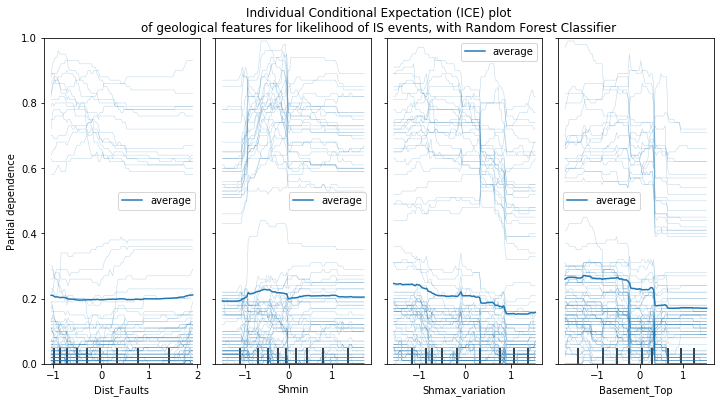

In [9]:
#modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title("Individual Conditional Expectation (ICE) plot\n"
    "of geological features for likelihood of IS events, with Random Forest Classifier")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Dist_Faults','Shmin','Shmax_variation','Basement_Top'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_RF_C_200dpi_small', dpi=200)

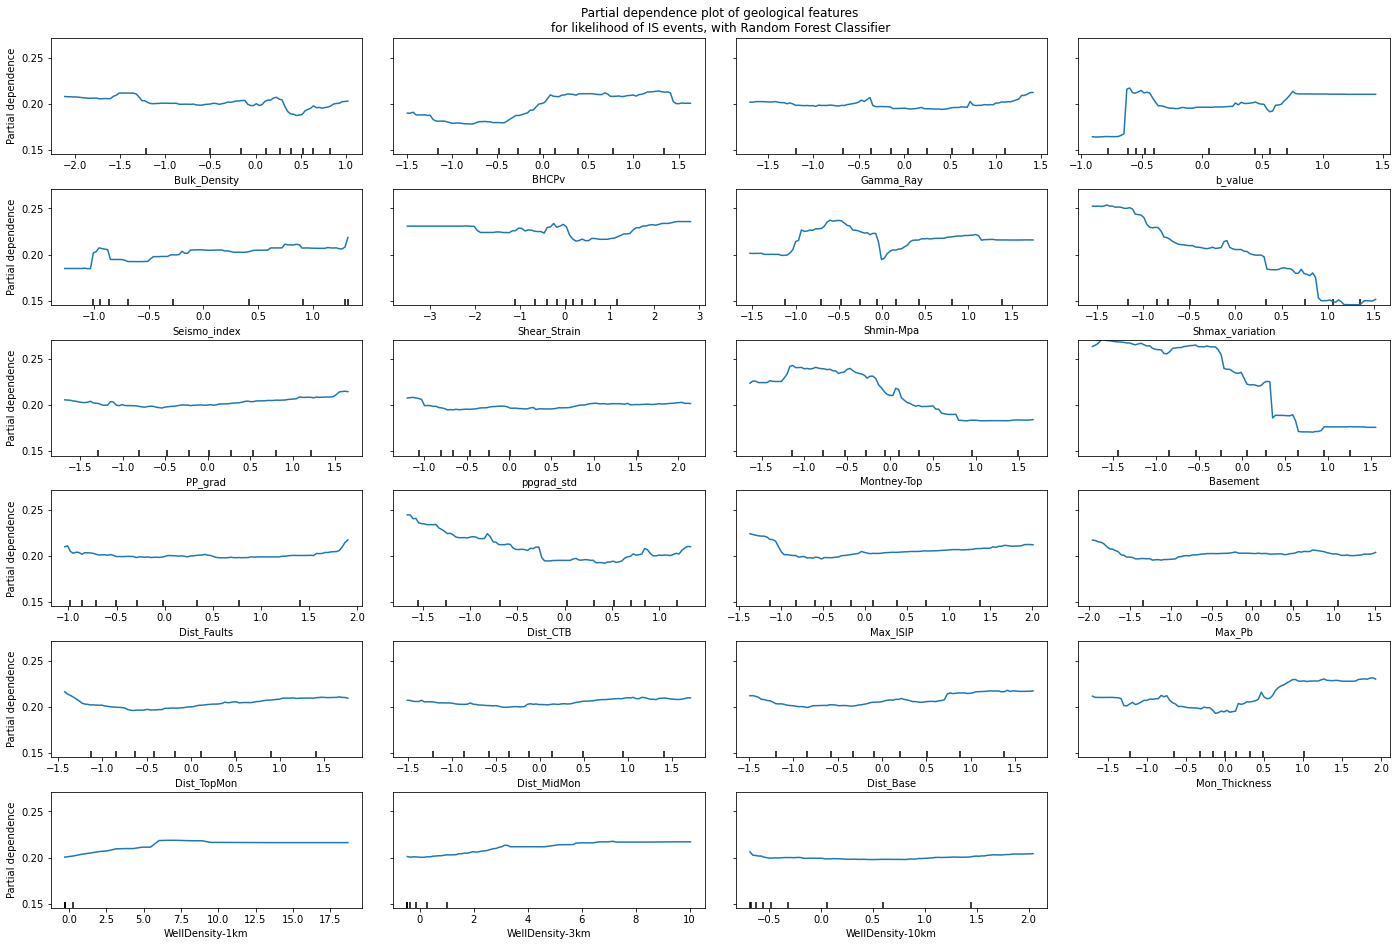

In [5]:
modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Partial dependence plot of geological features\n"
    "for likelihood of IS events, with Random Forest Classifier")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismo_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Mon_Thickness','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('PDP_RF_100dpi', dpi=100)

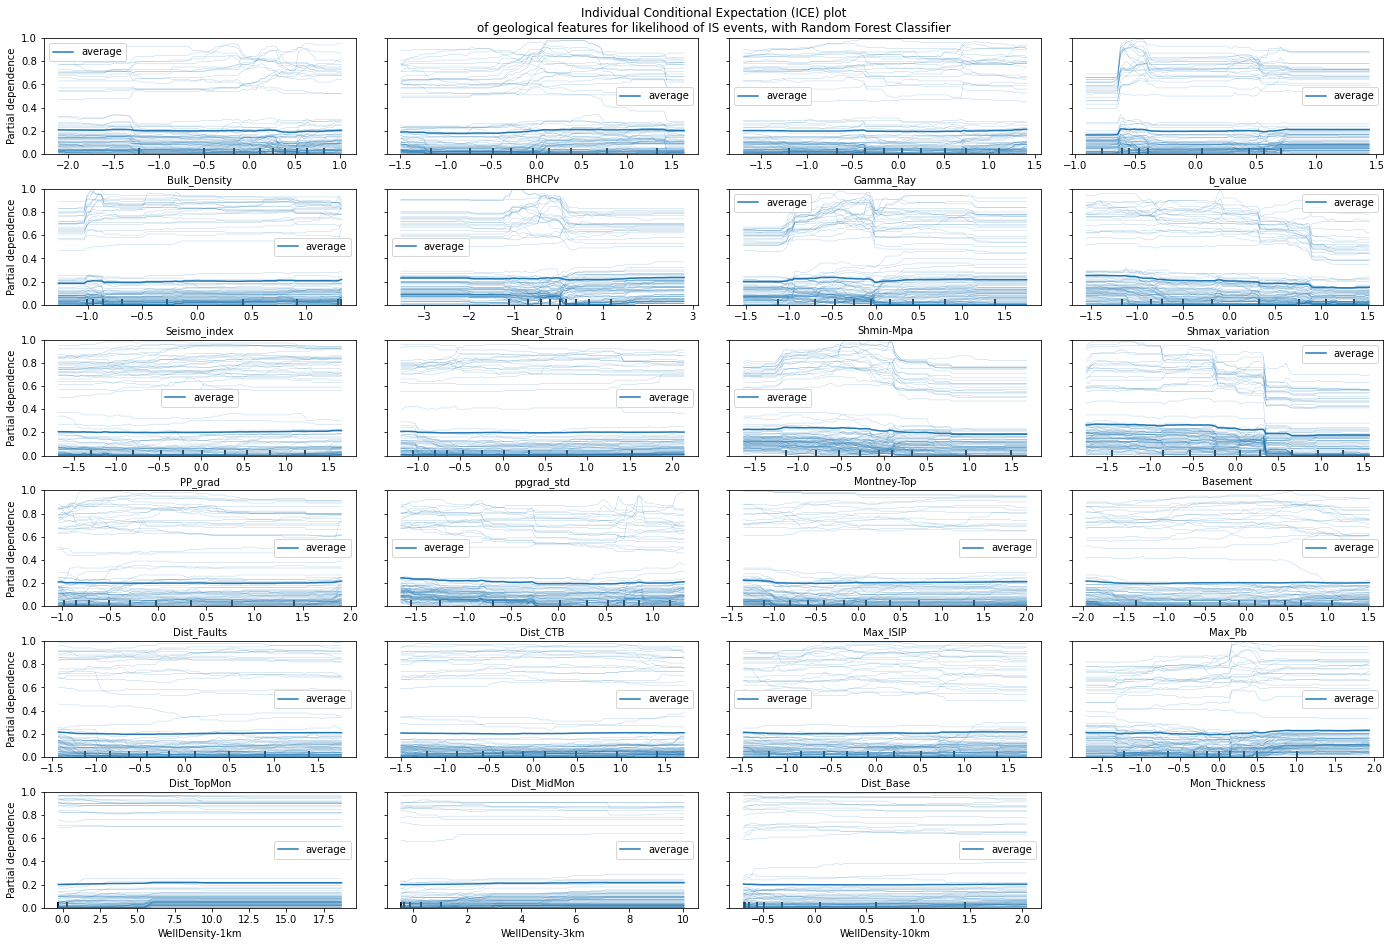

In [8]:
fig, ax = plt.subplots(figsize=(24, 16))
ax.set_title("Individual Conditional Expectation (ICE) plot\n"
    "of geological features for likelihood of IS events, with Random Forest Classifier")
display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismo_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Mon_Thickness','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
                               ax=ax, n_cols=4, kind="both", subsample=100)
display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
fig.savefig('ICE_plot_RFC_100dpi', dpi=100)

## SHAP plots

In [10]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80).fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


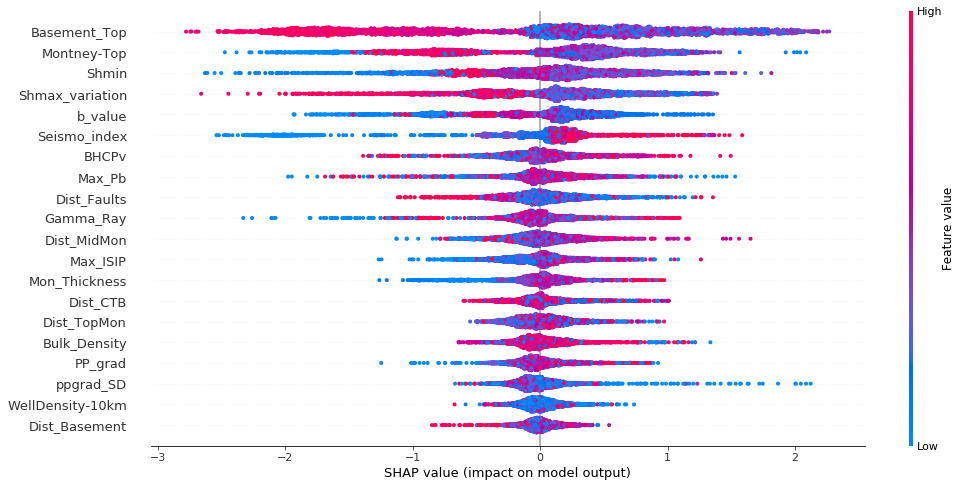

In [11]:
shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('LGBM_C_SHAP_summary_200dpi.png', dpi=200)

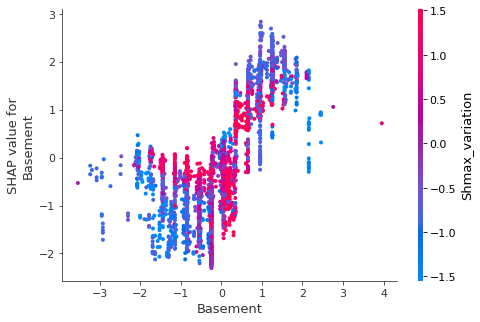

In [33]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(11, shap_values[0], X_train_scaled)

In [12]:
modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(modelrf)
shap_values = explainer.shap_values(X_train_scaled)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


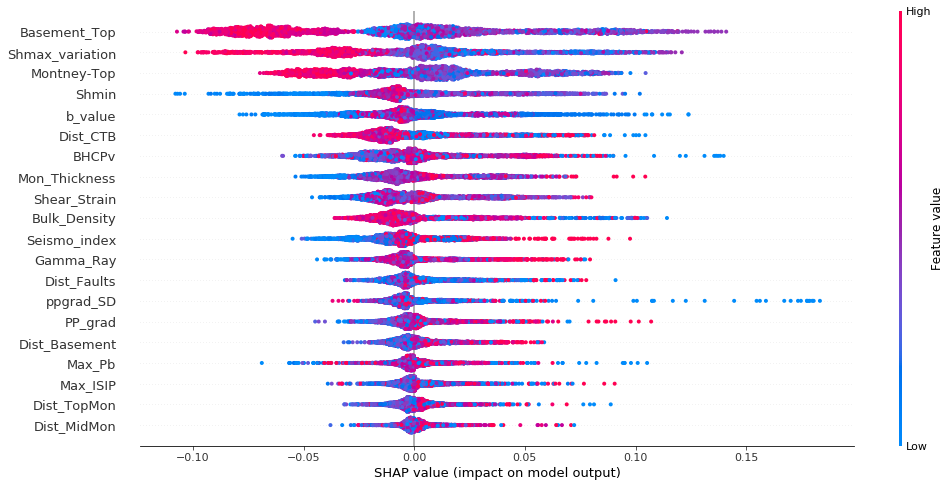

In [13]:
#fig, ax = plt.subplots(figsize=(30, 30))
fig = shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('RF_C_SHAP_summary_200dpi.png', dpi=200)

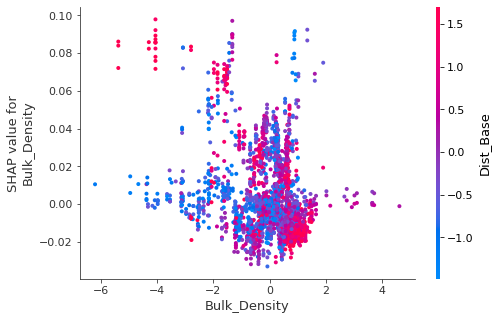

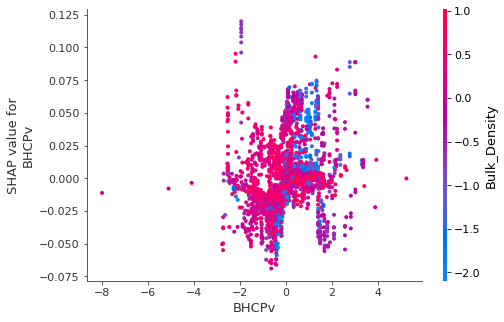

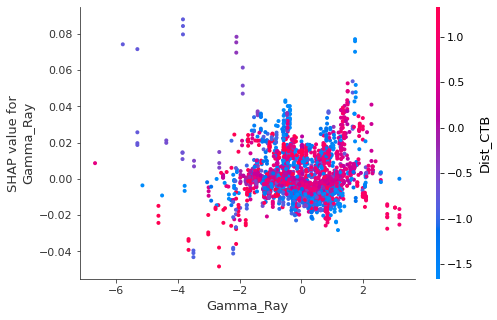

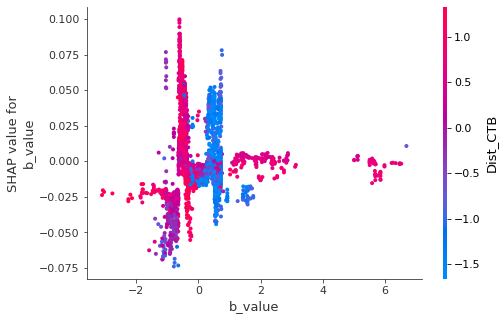

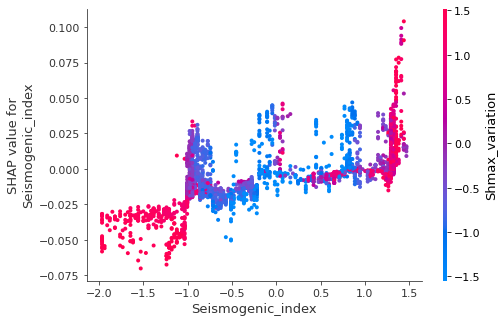

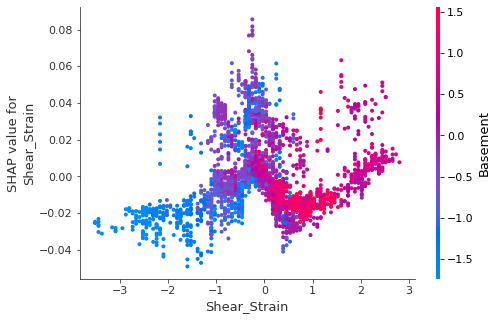

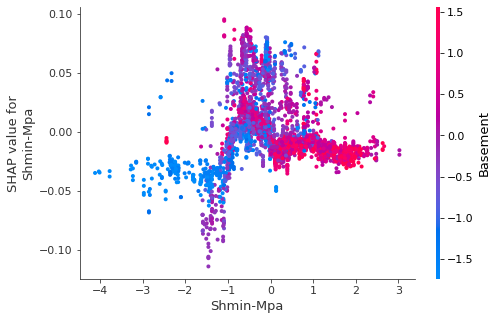

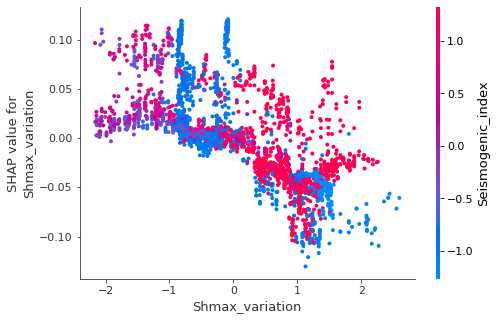

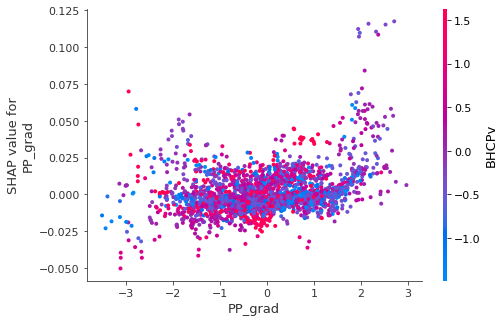

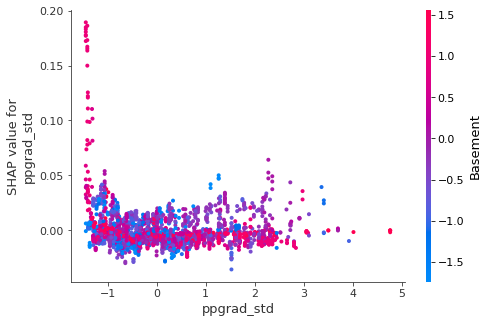

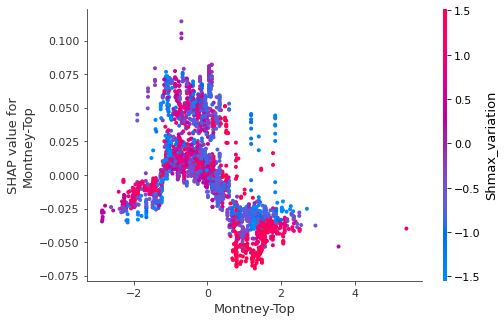

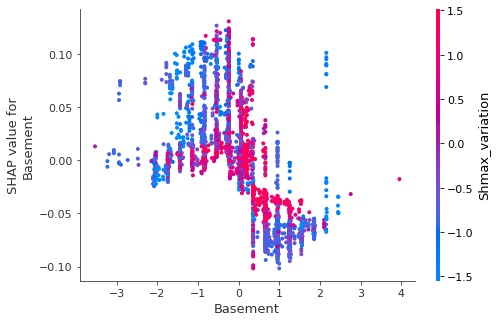

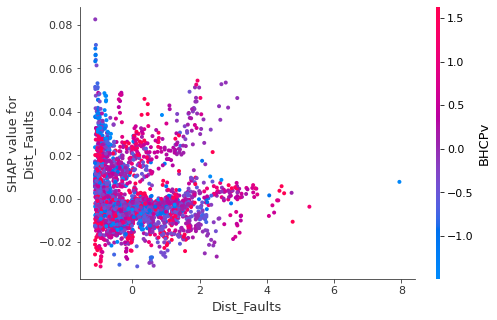

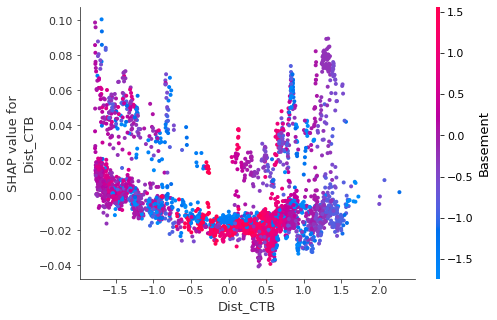

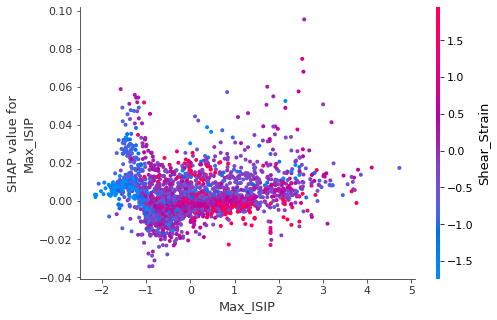

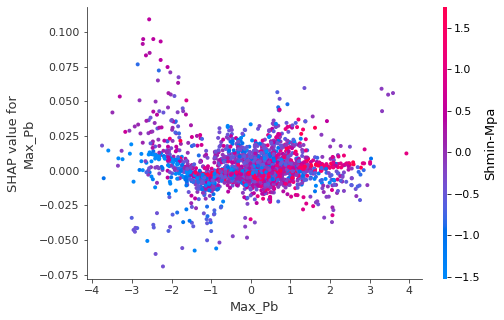

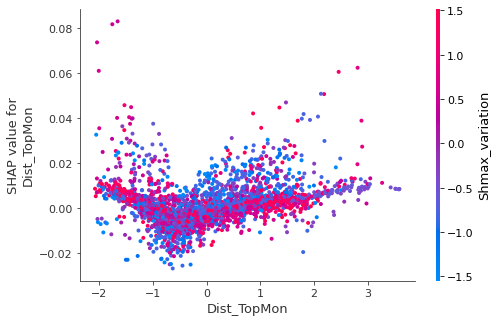

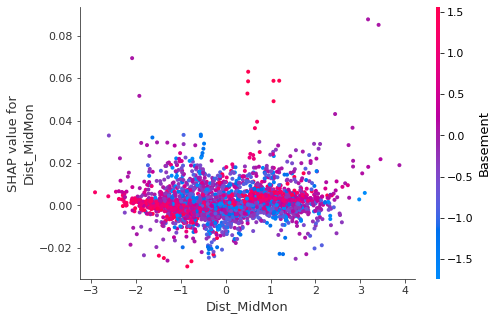

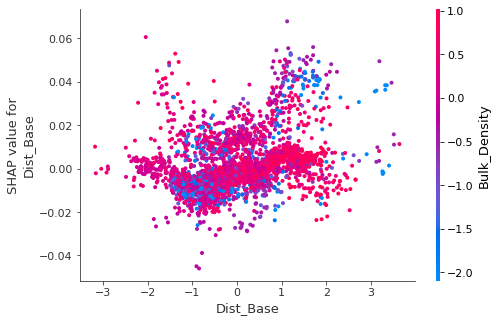

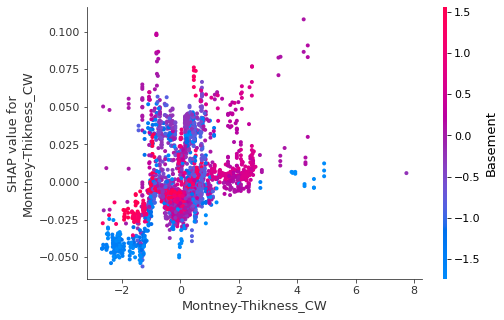

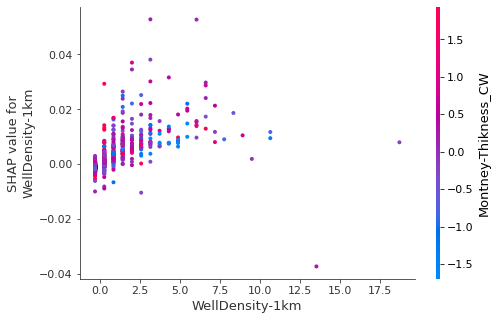

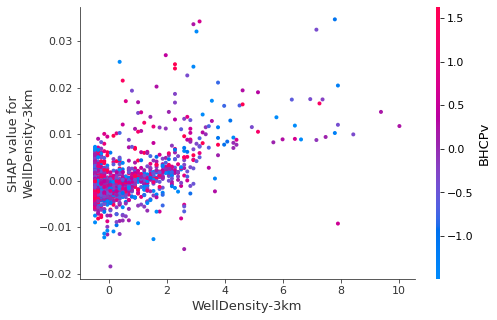

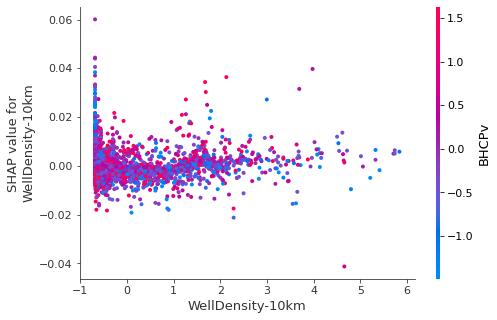

In [14]:
for name in X_train_scaled.columns:
    shap.dependence_plot(name, shap_values[1], X_train_scaled)

# Permutated Feature Importance

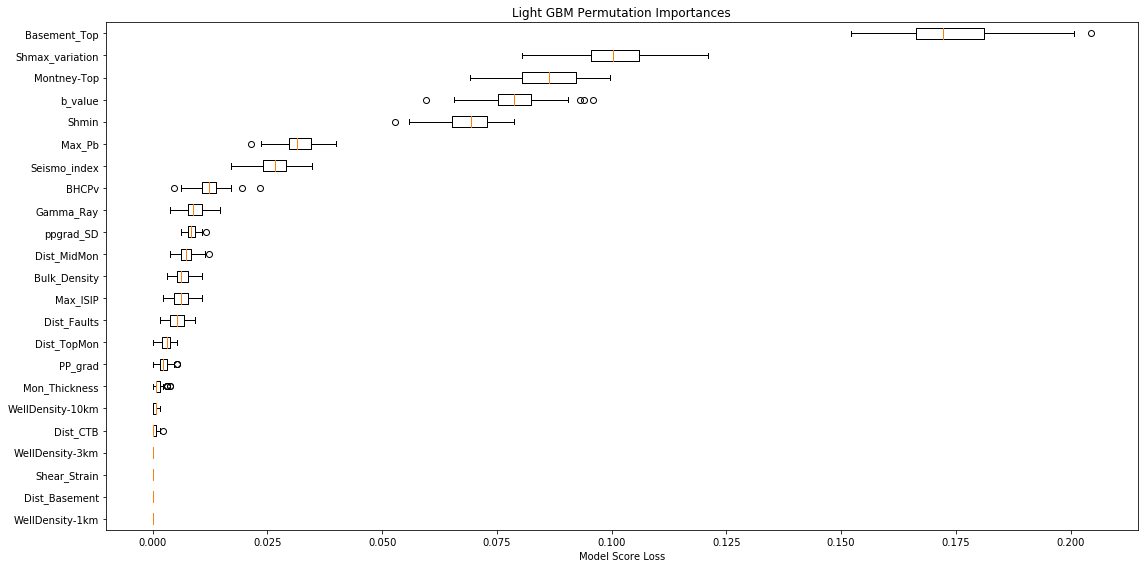

In [14]:
modellgb = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=467,num_leaves= 80).fit(X_train_scaled, y_train)
result = permutation_importance(modellgb, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("Light GBM Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_LGBM_200dpi', dpi=200)

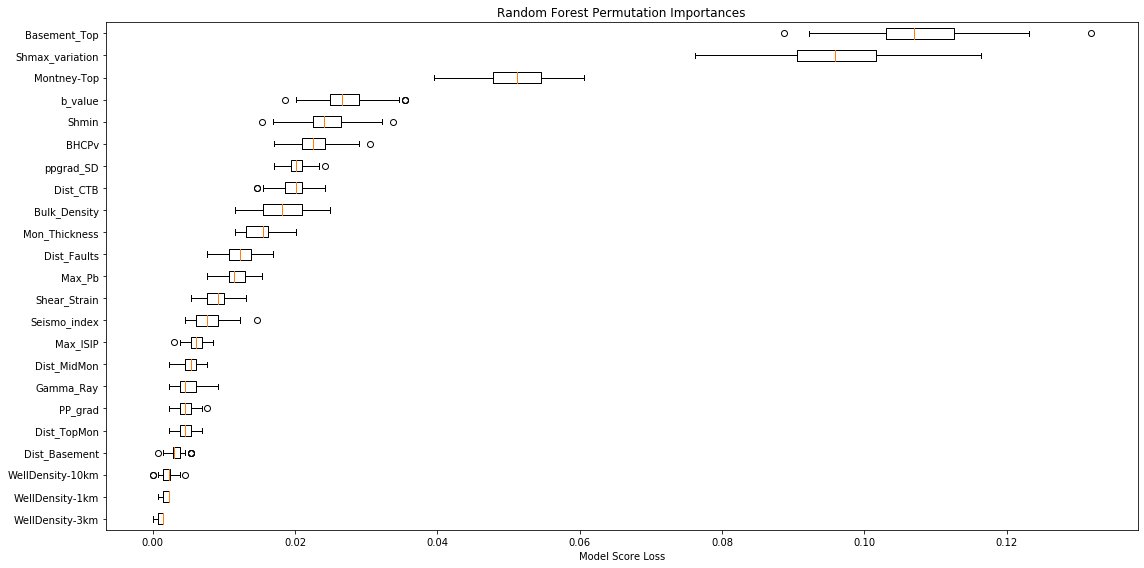

In [15]:
modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)
result = permutation_importance(modelrf, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_RF_200dpi', dpi=200)

[17:37:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


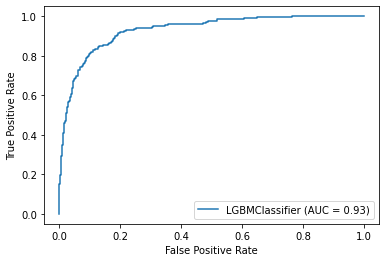

In [20]:
from matplotlib.pyplot import figure
#figure(figsize=(16, 12), dpi=200)
#ax = plt.gca()
modellgb = lgb.LGBMClassifier(learning_rate= 0.02,max_depth= 32,n_estimators=463,num_leaves= 80)
modellgb.fit(X_train_scaled, y_train)
modellgb_disp = plot_roc_curve(modellgb, X_test_scaled, y_test)
modelrf = RandomForestClassifier(max_depth= 28)
modelrf.fit(X_train_scaled, y_train)
#ax = plt.gca()
#fig, ax = plt.subplots(figsize=(12, 8))
modelrf_disp = plot_roc_curve(modelrf, X_test_scaled, y_test, ax=ax, alpha=0.8)
modelxgb = xgb.XGBClassifier(eta= 1.66e-05,gamma= 0.046 , max_depth=79,use_label_encoder=False)
modelxgb.fit(X_train_scaled, y_train)
modelxgb_disp = plot_roc_curve(modelxgb, X_test_scaled, y_test, ax=ax, alpha=0.7)
plt.show()
fig.savefig('ROC_200dpi', dpi=200)

[18:02:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


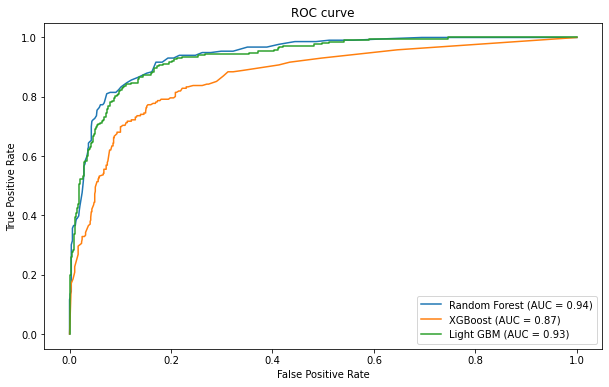

In [29]:
from sklearn.pipeline import make_pipeline
fig, ax = plt.subplots(figsize=(10, 6))

rf_model = make_pipeline(
    RandomForestClassifier(max_depth= 28))
rf_model.fit(X_train_scaled, y_train)

xgb_model = make_pipeline(
    xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79,use_label_encoder=False))
xgb_model.fit(X_train_scaled, y_train)

lgbm_model = make_pipeline(
    lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=463,num_leaves= 80,class_weight='balanced'))
lgbm_model.fit(X_train_scaled, y_train)




models = [
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("Light GBM", lgbm_model),

]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test_scaled, y_test, ax=ax, name=name)
_ = ax.set_title('ROC curve')
fig.savefig('ROC_200dpi', dpi=200)

[18:02:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


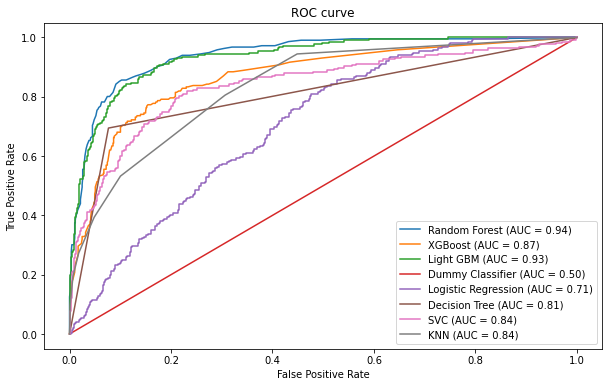

In [28]:
from sklearn.pipeline import make_pipeline
fig, ax = plt.subplots(figsize=(10, 6))

rf_model = make_pipeline(
    RandomForestClassifier(max_depth= 28))
rf_model.fit(X_train_scaled, y_train)

xgb_model = make_pipeline(
    xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79,use_label_encoder=False))
xgb_model.fit(X_train_scaled, y_train)

lgbm_model = make_pipeline(
    lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=463,num_leaves= 80,class_weight='balanced'))
lgbm_model.fit(X_train_scaled, y_train)

dm_model = make_pipeline(
    DummyClassifier(strategy="most_frequent"))
dm_model.fit(X_train_scaled, y_train)

lr_model = make_pipeline(
    LogisticRegression(C=0.0277167250884867, max_iter=100,class_weight='balanced'))
lr_model.fit(X_train_scaled, y_train)

dt_model = make_pipeline(
    DecisionTreeClassifier(max_depth= 93))
dt_model.fit(X_train_scaled, y_train)

svc_model = make_pipeline(
    SVC(C= 977647.5158109494,gamma=0.4890729726218923))
svc_model.fit(X_train_scaled, y_train)

knn_model = make_pipeline(
    KNeighborsClassifier(leaf_size= 16,n_neighbors= 8))
knn_model.fit(X_train_scaled, y_train)



models = [
    ("Random Forest", rf_model),
    ("XGBoost", xgb_model),
    ("Light GBM", lgbm_model),
    ("Dummy Classifier", dm_model),
    ("Logistic Regression", lr_model),
    ("Decision Tree", dt_model),
    ("SVC", svc_model),
    ("KNN", knn_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = plot_roc_curve(
        pipeline, X_test_scaled, y_test, ax=ax, name=name)
_ = ax.set_title('ROC curve')
fig.savefig('ROC_all_200dpi', dpi=200)

# preprocessing grid dataset

In [5]:
X = df_grid.drop(columns=['MiddleMontney','Lower_Form','Dist_Deb/Bell','WellDensity-5km','FID','POINT_X','POINT_Y'])

X_imp = imputer.transform(X)
 
X_scaled = scaler.transform(X_imp) # transforming the train split
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [19]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80,class_weight='balanced')
model.fit(X_train_scaled, y_train)
prob = model.predict_proba(X_scaled)
df = pd.DataFrame(prob)
df.to_excel(r'C:\Users\aamini\Desktop\GeoscienceBC Project\Project\lgbprob.xlsx')

In [20]:
prob

array([[0.98730015, 0.01269985],
       [0.98727513, 0.01272487],
       [0.98730015, 0.01269985],
       ...,
       [0.85142413, 0.14857587],
       [0.85581024, 0.14418976],
       [0.85581024, 0.14418976]])

# Results of applying LightGBM model on grid dataset

# Model Result

In [52]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 28),
    "XGBoost": xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79,use_label_encoder=False),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80)
                }

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict_proba(X_scaled)
    df = pd.DataFrame(y_pred)
#    filename = (i)
    filename = "Montney grid_" + str(key) + ".xlsx"
    df.to_excel(filename)

[16:11:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
